#### Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
from scipy.stats import normaltest, boxcox
from statsmodels.stats import diagnostic
from scipy import stats


%matplotlib inline

the dataset used in this challenge can be found here:
https://www.kaggle.com/dansbecker/nba-shot-logs

#### Dataset description: 
NBA data on shots taken during the 2014-2015 season, who took the shot, where on the floor was the shot taken from, who was the nearest defender, how far away was the nearest defender, time on the shot clock, and much more.

In [2]:
nba = pd.read_csv('nba-shot-logs/shot_logs.csv')
nba.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [3]:
def null_summary(df):
    row_count = len(df)
    
    #columns
    null_counts = len(df) - df.count()
    pct_nulls = round(100*null_counts/row_count,4)
    dtype = df.dtypes
    columns = ['null_counts', 'pct_nulls', 'dtype']
    
    null_df = pd.DataFrame([null_counts, pct_nulls, dtype]).T
    null_df.columns = columns
    
    print('total rows: ', row_count)
    return null_df
    
    

In [4]:
def look_at_nulls(df):
    null_rows = df[df.isnull().any(axis=1)]
    print('rows: ', len(null_rows))
    return null_rows

In [5]:
null_summary(nba)

total rows:  128069


,null_counts,pct_nulls,dtype
GAME_ID,0,0,int64
MATCHUP,0,0,object
LOCATION,0,0,object
W,0,0,object
FINAL_MARGIN,0,0,int64
SHOT_NUMBER,0,0,int64
PERIOD,0,0,int64
GAME_CLOCK,0,0,object
SHOT_CLOCK,5567,4.3469,float64
DRIBBLES,0,0,int64


In [6]:
null_df = look_at_nulls(nba)
null_df[['SHOT_CLOCK', 'GAME_CLOCK']].head()

rows:  5567


,SHOT_CLOCK,GAME_CLOCK
2,NaN,0:00
24,NaN,0:04
54,NaN,0:01
76,NaN,0:01
129,NaN,0:02


Our only null values are in the shot clock column. This is because the shot clock is turned off when there isn't enough game clock left in the quarter. We will replace these null values with the number of seconds left in the quarter.

In [7]:
# turn game clock into a number value using the last 2 digits of game clock
nba['game_clock_num'] = pd.to_numeric(nba['GAME_CLOCK'].str.slice(-2))

# use game clock number value to fillna in shot clock column
nba['SHOT_CLOCK'].fillna(nba['game_clock_num'], inplace=True)

In [8]:
# let's look at the data grouped by player
nba_players = nba.groupby(by='player_name',axis=0).mean()
nba_players.head()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id,game_clock_num
player_name,,,,,,,,,,,,,,,
aaron brooks,2.140048e+07,2.108734,5.944742,2.828877,11.799643,5.402852,4.959180,15.088592,2.388592,160550.399287,3.671836,0.415330,0.989305,201166.0,28.959002
aaron gordon,2.140045e+07,-5.336538,3.153846,2.288462,12.897115,1.355769,2.068269,10.062500,2.192308,161115.144231,4.152885,0.528846,1.144231,203932.0,27.692308
al farouq aminu,2.140048e+07,6.624031,3.651163,2.465116,13.153101,0.515504,1.401163,12.893411,2.368217,167449.918605,4.972093,0.430233,0.961240,202329.0,28.813953
al horford,2.140045e+07,6.153846,7.401399,2.527273,12.699301,0.537063,1.809231,11.973566,2.040559,152351.917483,4.886154,0.541259,1.095105,201143.0,30.130070
al jefferson,2.140041e+07,-2.163750,9.037500,2.446250,10.563125,0.696250,2.627250,9.315375,2.003750,149855.941250,3.029875,0.477500,0.957500,2744.0,29.018750


Let's predict player FG%. Since FGM is a binary column (1 for made, 0 for missed), the mean when grouped by player will be player FG% for the season. 

In [9]:
# pick features that are likely to affect FG%. It's important to remember that these are all averages.
features = nba_players[['DRIBBLES','SHOT_CLOCK','CLOSE_DEF_DIST','TOUCH_TIME','SHOT_DIST']]


# rename the grouped FGM to FG% in our features table
features['FG%'] = nba_players['FGM']
features.head()

c:\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DRIBBLES,SHOT_CLOCK,CLOSE_DEF_DIST,TOUCH_TIME,SHOT_DIST,FG%
player_name,,,,,,
aaron brooks,5.402852,11.799643,3.671836,4.959180,15.088592,0.415330
aaron gordon,1.355769,12.897115,4.152885,2.068269,10.062500,0.528846
al farouq aminu,0.515504,13.153101,4.972093,1.401163,12.893411,0.430233
al horford,0.537063,12.699301,4.886154,1.809231,11.973566,0.541259
al jefferson,0.696250,10.563125,3.029875,2.627250,9.315375,0.477500


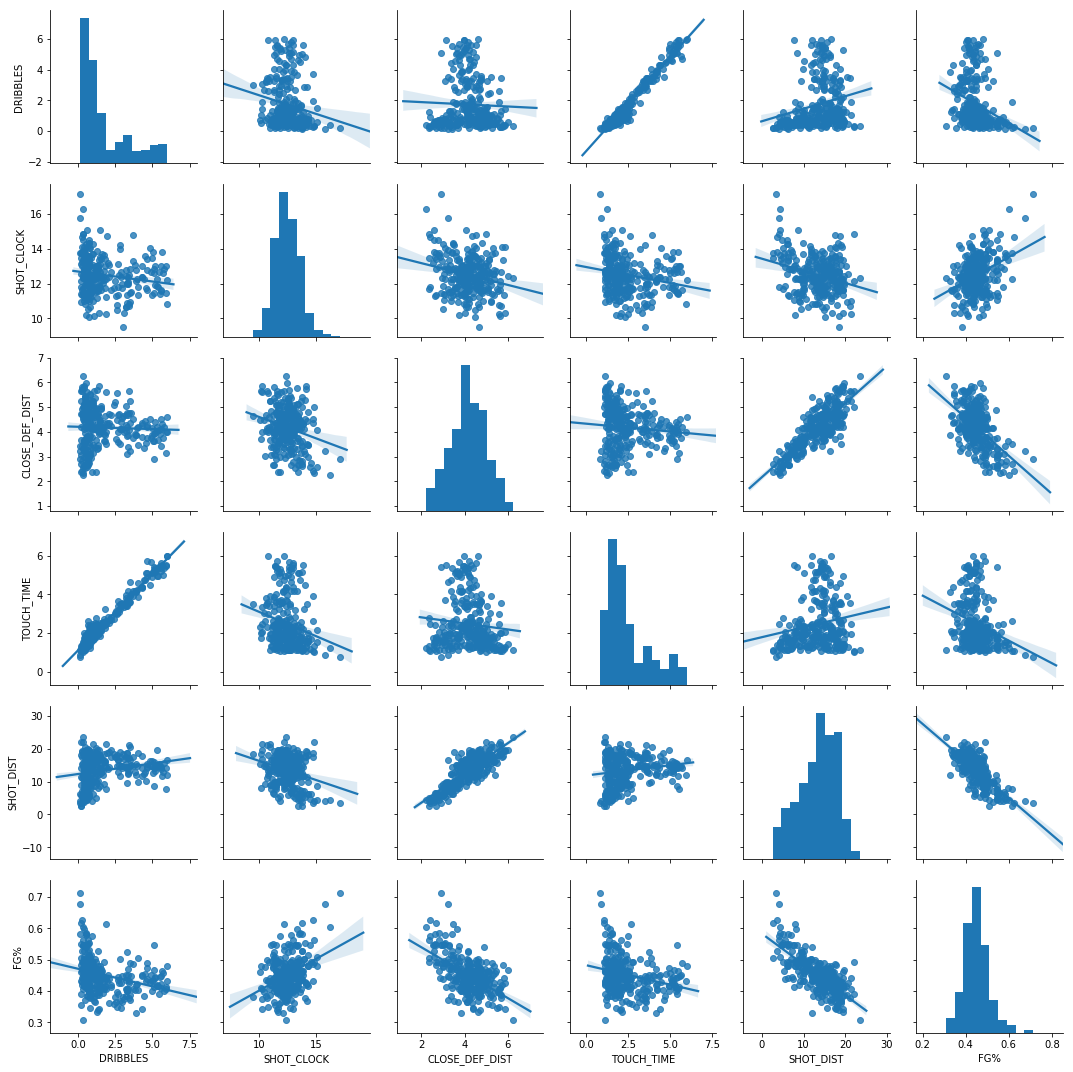

In [10]:
# inspect pair plot for non-linear relationships and high colinearity among features
sns.pairplot(features, kind='reg')

Dribbles and touch time are highly correlated. So are shot distance and closest defender distance. For simplicity we will ignore touch time and closest defender distance since dribbles and shot distance are easier to identify as a fan/spectator of the game.

In [11]:
from functools import reduce

def display_equation(linear_model, X, Y):
    equation_parts = ['{} = '.format(Y.name)]
    for i, coef in enumerate(linear_model.coef_):
        equation_parts.append('({}*{}) + '.format(round(coef, 4), X.columns[i]))
    equation_parts.append('{}'.format(round(linear_model.intercept_, 4)))
    print(reduce(lambda x, y: x+y, equation_parts))
        

In [12]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['FG%']
X = features[['DRIBBLES','SHOT_CLOCK','SHOT_DIST']]
regr.fit(X, Y)

# Inspect the results.
print('linear equation:')
display_equation(regr, X, Y)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = Y

# Calculate the error, also called the residual.
residual = actual - predicted


print('\nresidual normal test now (pval): ', normaltest(residual)[1])
print( '\nresidual homoscedasticity test now (pval): ', diagnostic.het_breuschpagan(residual, predicted.reshape(len(predicted),1)))

linear equation:
FG% = (-0.0045*DRIBBLES) + (0.0088*SHOT_CLOCK) + (-0.0088*SHOT_DIST) + 0.4673

R-squared:
0.593346408715

residual normal test now (pval):  0.364244220694

residual homoscedasticity test now (pval):  (87.730632049803148, nan, 127.10020855594078, 1.4837486730467763e-24)


#### The linear equation from this model makes sense based on what I know of the game.
- More dribbles before shooting decreases shot percentage,
- Shots earlier in the shot clock (higher shot clock value) are more successful
- Shots closer to the basket (lower shot distance value) are more successful.

In [13]:
def diagnostic_graphs_LR(actual, predicted):
    residual = actual - predicted
    
    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    
    # graph 1: residual plot
    sns.scatterplot(predicted, residual, ax=axes[0][0])
    axes[0][0].axhline(y=0)
    
    # graph 2: residual distribution
    sns.distplot(residual, ax=axes[0][1])
    
    # graph 3: actual vs predicted scatter
    sns.scatterplot(predicted, actual, ax=axes[1][0])
    axes[1][0].set(xlabel='Predicted', ylabel='Actual')
    min_val = min(min(predicted), min(actual))
    max_val = max(max(predicted), max(actual))
    axes[1][0].plot([min_val, max_val],[min_val, max_val])

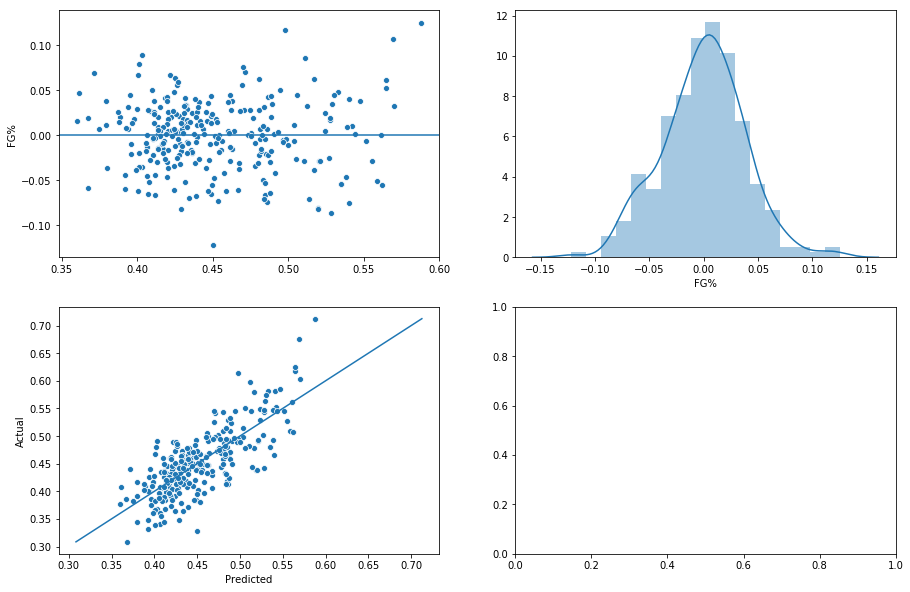

In [14]:
diagnostic_graphs_LR(actual, predicted)

The residuals seem normal and the residuals plot passes the eye test for homoscedasticity

In [15]:
from sklearn.model_selection import cross_val_score
def display_cv_score(model, X, Y, cv=10):
    score = cross_val_score(model, X, Y, cv=10)
    print('accuracy = {} +/- {}'.format(round(score.mean(),4), round(score.std()*2,4)))

In [16]:
display_cv_score(regr,X,Y)

accuracy = 0.5096 +/- 0.3609


Not a great cross validation result

In [17]:
# build knn regression model
from sklearn import neighbors
from sklearn import preprocessing

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=35)
Y = features['FG%']
X = preprocessing.scale(features[['DRIBBLES','SHOT_CLOCK','SHOT_DIST']])
knn.fit(X, Y)

# Extract predicted values.
predicted = knn.predict(X).ravel()
actual = Y

display_cv_score(knn,X,Y)

accuracy = 0.4811 +/- 0.2449


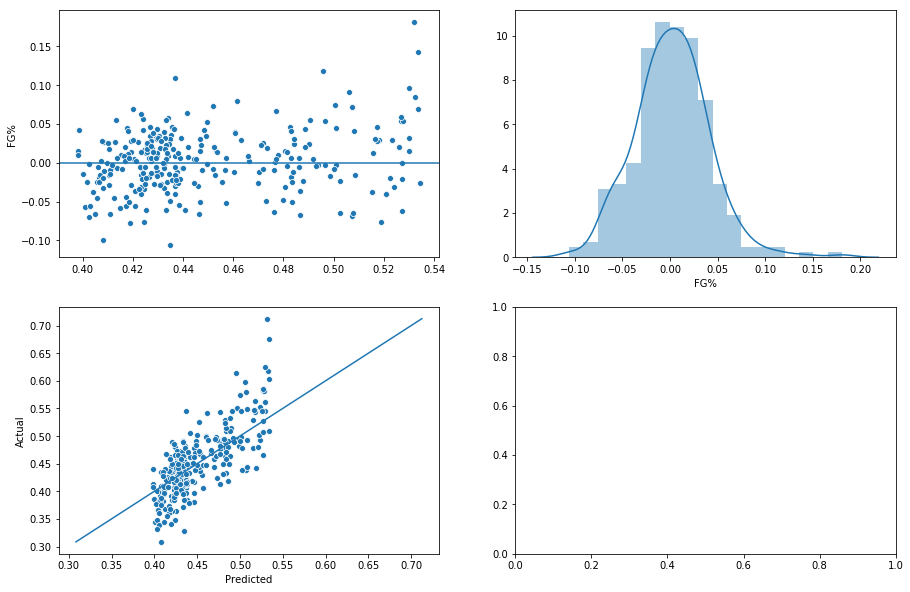

In [18]:
# re-using this function for convenience but only focusing on 3rd plot (bottom left)
diagnostic_graphs_LR(actual, predicted)

### Summary

Neither model was great, but I suppose this is not too surprising considering that the features used and the dependent variable were all averages. They both had similar r squared scores when cross validated, but the nearest neighbor model had less variance. In order to achieve less variance with the nearest neighbors model, the neighbors parameter was set a bit high to 35. This resulted in greater error when player had extreme actual FG% values. 

I would prefer the linear regression model because of its explanatory power. Predicting a players FG% across a season based on the selected features is unlikely to be valuable without understanding how each feature contributes. This is because the features and the predicted variable happen simultaneously, so there is no real world situation in which you would know one without the other. 

